## Imports
---

In [202]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime
from src.heikin_ashi import heikin_ashi
from src.indicators import supertrend, VWAP2, smc, wavetrend3d, atr, pivotPoints, choch, find_extrema, vwma
from src.backtesting_lib import evaluatePairs, format_data
import pandas_ta as ta
from scipy.signal import argrelextrema
import csv
import plotly.graph_objects as go
import plotly.express as px

## Getting the Data
---

# Kleines Tutorial für Backtesting.py

Es besteht aus einen init part wo alle variablen definiert und initialisiert werden und einen next part wo der algorithmus nach und nach jede candle durchgeht. Dabei kann man die zurzeitige Candle mit __self.data.Close[-1]__ abrufen. Dir davor mit -2 usw. Ihr könnt außerdem dabei zwischen Close, Open, High, Low entscheiden. 

Um die zurzeitige Balance zu bekommen ruft ihr self.equity auf. 

Um Indicatoren hinzuzufügen habt ihr folgende Syntax:

__self.IndicatorName = self.I(Indicator, Parameter1, Parameter2, ...)__

Dabei könnt ihr die jetzigen Werte abrufen wie mit den Daten [-n],  $n \in \mathbb{N}$ .

Um Trades einzugehen bentzt man entweder:

__self.buy(size=deineGroesse)__ 

__self.sell(size=deineGroesse)__

Ihr müsst dabei geachten das man entweder die Share anzahl als Integer übergebt oder die eine Kommazahl von $[0,1)$ die darstellt wie viel Prozent deines Portfolios du reinsetzt hast.

um eine Position zu schließen benutzt ihr: 

__self.position.close()__

Das sind so die wichtigsten Befehle. Leider lässt die libary nicht mehrere Positionen gleichzeitig. Falls ihr das umbedingt braucht kann ich nach einer anderen Libary ausschau halten. 

Falls ihr irgendwelche anderen Befehle braucht wie z.B. eine LimitOrder oder sowas dann findet ihr die unter den Documentations: 

- https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#gsc.tab=0


## The Strategy
---

In [66]:
von = 900
bis = 1000

auxusd = format_data("AUXUSD")

left_cand = 24
right_cand = 3

fig = go.Figure(data=[go.Candlestick(x=auxusd[von:bis].index,
                open=auxusd['Open'][von:bis],
                high=auxusd['High'][von:bis],
                low=auxusd['Low'][von:bis],
                close=auxusd['Close'][von:bis])])
fig.add_scatter(x=auxusd[von:bis].index, y=find_extrema(auxusd, left_cand, right_cand)["higher_high"][von:bis], mode="markers", marker=dict(color="blue", size=8))
fig.add_scatter(x=auxusd[von:bis].index, y=find_extrema(auxusd, left_cand, right_cand)["lower_low"][von:bis], mode="markers", marker=dict(color="black", size=8))
fig.add_scatter(x=auxusd[von:bis].index, y=find_extrema(auxusd, left_cand, right_cand)["higher_low"][von:bis], mode="markers", marker=dict(color="orange", size=8))
fig.add_scatter(x=auxusd[von:bis].index, y=find_extrema(auxusd, left_cand, right_cand)["lower_high"][von:bis], mode="markers", marker=dict(color="brown", size=8))
fig.add_scatter(x=auxusd[von:bis].index, y=np.where(choch(auxusd, 20, 3) == 0, np.nan, choch(auxusd, 20, 3))[von:bis], mode="markers", marker=dict(color="purple", size=8))
fig.update_layout(xaxis_rangeslider_visible=False, width=800)
fig.show()

In [52]:
np.where(choch(auxusd, 20, 3) == 0, np.nan, choch(auxusd, 20, 3))

array([nan, nan, nan, ..., nan, nan, nan])

# ChoCh Strat mit VWAP
---

In [208]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import warnings

warnings.filterwarnings("ignore")

class chocho(Strategy):
    shorts = True
    longs = True
    tradehourStart = 1 #UTC Time
    tradehourEnd = 20 #UTC Time
    timeframeChoch = "3T"
    chochLeft = 60
    chochRight = 3
    stoplosscandles = 10
    atr_window = 14
    uuvwap = True # Macht nur trades wenn der Kurs über dem VWAP ist (oder unter)
    supertrendlookback = 10
    supertrendmultiplier = 3
    vwmaoff = True
    vwmaLength = 60
    taggedduration = 7
    vwmaduration = 2
    atr_threshold = 0
    close22 = True

    def init(self):
        self.sholong = 0
        self.lastdiffs = []
        self.stoploss = 0
        self.vwap = self.I(VWAP2, self.data.df, 0)
        self.taggedshort = False
        self.taggedlong = False
        self.taggedcountershort = 0 # How long a tag is valid to enter with chocho
        self.taggedcounterlong = 0 
        self.fees = 0
        self.entryal = False
        self.index = 0
        self.vwmacounter = 0
        self.length = len(self.data.df)
        self.vwapu1 = self.I(VWAP2, self.data.df, 1)
        self.vwapl1 = self.I(VWAP2, self.data.df, 2)
        self.vwapu2 = self.I(VWAP2, self.data.df, 3)
        self.vwapl2 = self.I(VWAP2, self.data.df, 4)
        self.vwapu3 = self.I(VWAP2, self.data.df, 5)
        self.vwapl3 = self.I(VWAP2, self.data.df, 6)
        self.vwma = self.I(vwma, self.data.Close, self.data.Volume, self.vwmaLength)
        self.chochLong = self.I(choch, self.data.df, self.chochLeft, self.chochRight, self.timeframeChoch, 1)
        self.chochShort = self.I(choch, self.data.df, self.chochLeft, self.chochRight, self.timeframeChoch, 0)
        self.supertrendu = self.I(supertrend, self.data.df, self.supertrendlookback, self.supertrendmultiplier, 0)
        self.supertrendl = self.I(supertrend, self.data.df, self.supertrendlookback, self.supertrendmultiplier, 1)
        self.atr = self.I(atr, self.data.df, self.atr_window)

        
    def next(self):
        if self.data.index[-1].hour >= self.tradehourStart and self.data.index[-1].hour <= self.tradehourEnd and not self.position:
            if self.shorts:
                if not self.taggedshort:
                    if ((self.data.High[-1] > self.vwapu2[-1] - (self.atr[-1]/2) and self.data.High[-1] < self.vwapu2[-1] + (self.atr[-1]/2)) or (self.data.High[-1] > self.vwapu3[-1] - (self.atr[-1]/2) and self.data.High[-1] < self.vwapu3[-1] + (self.atr[-1]/2))):
                        self.taggedshort = True
                elif (self.chochShort[-1] > 0 and self.atr[-1] > self.atr_threshold and self.taggedshort and self.taggedcountershort < self.taggedduration and (self.data.Close[-1] > self.vwap[-1] or not self.uuvwap)) or self.entryal:
                    self.entryal = True
                    if (self.data.Low[-1] < self.vwma[-1] and self.data.High[-1] > self.vwma[-1] and self.vwmacounter < self.vwmaduration) or self.vwmaoff:
                        self.stoploss = 0
                        for i in range(1, self.stoplosscandles):
                            if self.data.High[-i] > self.stoploss:
                                self.stoploss = self.data.High[-i]
                        def berechnen(kapital, stoploss, entry):
                            diff = abs(stoploss - entry)
                            if(diff < 0.0000001):
                                diff = abs(sum(self.lastdiffs) / len(self.lastdiffs))
                            self.lastdiffs.append(diff)
                            size = abs((kapital/200) / abs(diff))
                            return int(round(size,0))
                        sizeO = berechnen(self.equity, self.stoploss, self.data.Close[-1])
                        self.sell(size=sizeO, sl=self.stoploss)
                        self.sholong = 1
                        self.entryal = False
                    elif self.vwmacounter >= self.vwmaduration:
                        self.entryal = False
                        self.vwmacounter = 0
                    else:
                        self.vwmacounter += 1
                if self.taggedshort:
                    self.taggedcountershort += 1
                if self.taggedcountershort > self.taggedduration:
                    self.taggedshort = False    
                    self.taggedcountershort = 0
            if self.longs and not self.position:
                if not self.taggedlong:
                    if((self.data.Low[-1] < self.vwapl2[-1] + (self.atr[-1]/2) and self.data.Low[-1] > self.vwapl2[-1] - (self.atr[-1]/2)) or (self.data.Low[-1] < self.vwapl3[-1] + (self.atr[-1]/2) and self.data.Low[-1] > self.vwapl3[-1] - (self.atr[-1]/2))):
                        self.taggedlong = True
                if (self.chochLong[-1] > 0 and self.atr[-1] > self.atr_threshold and self.taggedlong and self.taggedcounterlong < self.taggedduration and (self.data.Close[-1] < self.vwap[-1] or not self.uuvwap)) or self.entryal:
                    self.entryal = True
                    if (self.data.Low[-1] < self.vwma[-1] and self.data.High[-1] > self.vwma[-1] and self.vwmacounter < self.vwmaduration) or self.vwmaoff:
                        self.stoploss = 10000000
                        for i in range(1, self.stoplosscandles):
                            if self.data.Low[-i] < self.stoploss:
                                self.stoploss = self.data.Low[-i]
                        def berechnen(kapital, stoploss, entry):
                            diff = abs(stoploss - entry)
                            if(diff < 0.0000001):
                                diff = abs(sum(self.lastdiffs) / len(self.lastdiffs))
                            self.lastdiffs.append(diff)
                            size = abs((kapital/200) / abs(diff))
                            return int(round(size,0))
                        sizeO = berechnen(self.equity, self.stoploss, self.data.Close[-1])
                        self.buy(size=sizeO, sl=self.stoploss)
                        self.sholong = 0
                        self.entryal = False
                    elif self.vwmacounter >= self.vwmaduration:
                        self.entryal = False
                        self.vwmacounter = 0
                    else:
                        self.vwmacounter += 1
                if self.taggedlong:
                    self.taggedcounterlong += 1
                if self.taggedcounterlong > self.taggedduration:
                    self.taggedlong = False
                    self.taggedcounterlong = 0
        elif self.position:
            if self.sholong == 0:
                if(self.supertrendl[-2] > 0 and self.supertrendu[-1] > 0):
                    self.position.close()
                    self.tagged = False
            elif self.sholong == 1:
                if(self.supertrendu[-2] > 0 and self.supertrendl[-1] > 0):
                    self.position.close()
                    self.tagged = False
            if self.data.index[-1].hour >= 22 and self.close22:
                self.position.close()
                self.tagged = False

data = format_data("EURUSD_NEW", "3T")

bt = Backtest(data[:1000000], chocho, cash=10000, commission=0.00003, margin=0.01)
stats = bt.run()
stats


In [109]:
bt.plot()

GridPlot(id='p27184', ...)

In [4]:
idk = choch(auxusd, 6, 3)

In [6]:
idk[idk > 0][:40]

Date
2021-06-07 01:03:00    1890.50
2021-06-07 08:06:00    1883.23
2021-06-07 09:30:00    1883.36
2021-06-07 10:57:00    1884.92
2021-06-07 12:24:00    1885.21
2021-06-07 15:39:00    1892.97
2021-06-07 20:21:00    1899.00
2021-06-08 01:33:00    1901.31
2021-06-08 02:30:00    1897.60
2021-06-08 05:24:00    1896.78
2021-06-08 05:57:00    1896.97
2021-06-08 07:15:00    1896.08
2021-06-08 07:51:00    1893.89
2021-06-08 09:39:00    1891.70
2021-06-08 12:42:00    1899.38
2021-06-08 17:00:00    1892.10
2021-06-08 19:12:00    1892.89
2021-06-09 01:27:00    1894.59
2021-06-09 02:00:00    1893.20
2021-06-09 02:33:00    1891.93
2021-06-09 03:21:00    1894.50
2021-06-09 05:48:00    1893.84
2021-06-09 08:12:00    1891.92
2021-06-09 12:06:00    1890.26
2021-06-09 14:03:00    1895.37
2021-06-09 14:36:00    1890.39
2021-06-09 16:03:00    1891.19
2021-06-09 17:39:00    1891.29
2021-06-10 00:09:00    1887.90
2021-06-10 02:00:00    1887.11
2021-06-10 04:06:00    1886.60
2021-06-10 05:36:00    1885.94
202

In [32]:
bt.plot()

GridPlot(id='p9148', ...)

# Parameter Optimization
---

In [33]:

data = format_data("EURUSD_NEW", "3T")

bt = Backtest(data[:300000], chocho, cash=10000, commission=0.00003, margin=0.01)
output = bt.run()

stats, heatmap = bt.optimize(
    atr_threshold = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005], 
    chochLeft = [60, 70],
    maximize='Sharpe Ratio',
    max_tries=100,
    return_heatmap=True,
    random_state=0,
)

  0%|          | 0/10 [00:00<?, ?it/s]

## Get 3 best results

In [25]:
hm = heatmap.groupby(['chochLeft', 'atr_threshold']).mean().unstack()
hm

atr_threshold,0.9,1.0,1.1,1.2
chochLeft,,,,
60,NaN,NaN,NaN,NaN


<Axes: xlabel='atr_threshold', ylabel='chochLeft'>

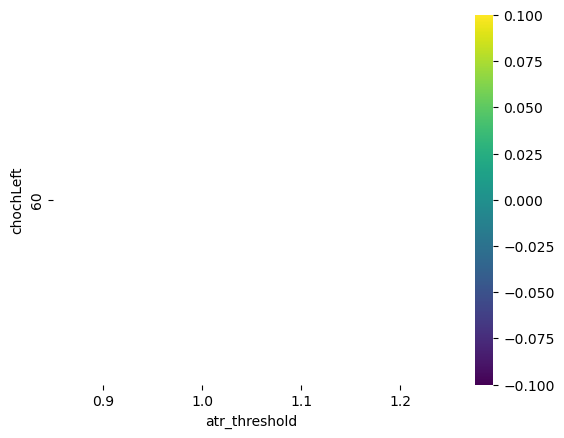

In [34]:
%matplotlib inline

sns.heatmap(hm[::1], cmap='viridis')

# Backtesting multiple pairs at the same time
---

In [ ]:
pairsList = ["AUXUSD", "EURUSD_2021_2023"]
 
evaluatePairs(pairsList, PIES)

In [84]:
bt.plot()

GridPlot(id='p19429', ...)

In [134]:
from numba import jit